In [2]:
# Import RealSense, OpenCV and NumPy
import pyrealsense2 as rs
import cv2
import numpy as np
import pyvista as pv
from pclpy import pcl
import open3d as o3d
import trimesh
import matplotlib.pyplot as plt

from natsort import natsorted

from interactivecrop.interactivecrop import main as crop 
from interactivecrop.samples import sample_images, sample_names

import os 
os.sys.path.append('./box_dimensioner_multicam/')

# Import helper functions and classes written to wrap the RealSense, OpenCV and Kabsch Calibration usage
from collections import defaultdict
from realsense_device_manager import DeviceManager
from calibration_kabsch import PoseEstimation
from helper_functions import get_boundary_corners_2D, convert_pointcloud_to_depth
from measurement_task import calculate_boundingbox_points, calculate_cumulative_pointcloud, visualise_measurements

%load_ext autoreload
%autoreload 2

### Enable Devices 

In [2]:
### camera parameters 
resolution_width = 640 # pixels
resolution_height = 480 # pixels
frame_rate = 30  # fps
dispose_frames_for_stablisation = 30  # frames
num_devices = 2 # realsense cameras 

# Enable the streams from all the intel realsense devices
rs_config = rs.config()
rs_config.enable_stream(rs.stream.depth, resolution_width, resolution_height, rs.format.z16, frame_rate)
rs_config.enable_stream(rs.stream.infrared, 1, resolution_width, resolution_height, rs.format.y8, frame_rate)
rs_config.enable_stream(rs.stream.color, resolution_width, resolution_height, rs.format.bgr8, frame_rate)

# Use the device manager class to enable the devices and get the frames
device_manager = DeviceManager(rs.context(), rs_config)
device_manager.enable_all_devices()
device_manager.stabilize_devices() 

0 devices have been found


### Calibrate Device

In [4]:
device_manager.calibrate()
device_manager.load_calibration_params()

Starting calibration, place chessboard on plane
RMS error for calibration with device number 013422062082 is : 0.016290038746206173 m
RMS error for calibration with device number 020122061309 is : 0.017239125651299984 m
RMS error for calibration with device number 013422062082 is : 0.017015286572172404 m
RMS error for calibration with device number 013422062082 is : 0.017113080961649423 m
RMS error for calibration with device number 013422062082 is : 0.017229861548315357 m
RMS error for calibration with device number 013422062082 is : 0.01786672341454234 m
RMS error for calibration with device number 013422062082 is : 0.01647131385652987 m
RMS error for calibration with device number 013422062082 is : 0.017654758665214 m
RMS error for calibration with device number 013422062082 is : 0.01641675630564995 m
RMS error for calibration with device number 013422062082 is : 0.018076251608011105 m
RMS error for calibration with device number 013422062082 is : 0.018228888045518383 m
RMS error fo

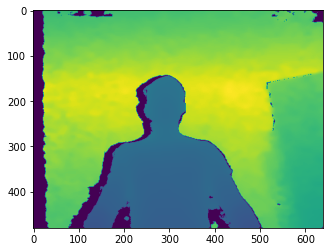

In [5]:
depth_imgs, pcd = device_manager.evaluate_volume()

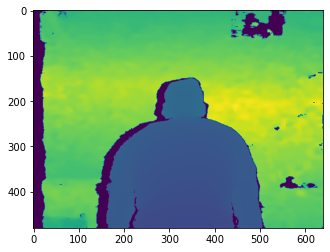

In [6]:
plt.imshow(depth_imgs[1])

### Validate Distance Volumes

Done Recording.


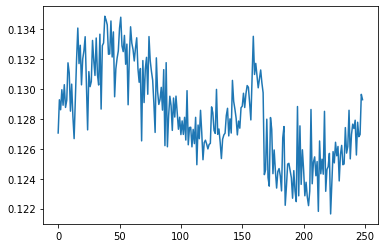

In [7]:
min_thresh, max_thresh = 1.1, 2
depth_imgs, depth_distances = device_manager.evaluate_distance(250, min_thresh, max_thresh)

### Capture Frames 

In [323]:
depth_save_path = 'D:/realsense_demos/dual_depth_demo_2/run_8_depth'  

if not os.path.isdir(depth_save_path): 
    os.makedirs(depth_save_path)

In [324]:
depth_results = device_manager.capture_frames(765, depth_save_path)

Done Recording.


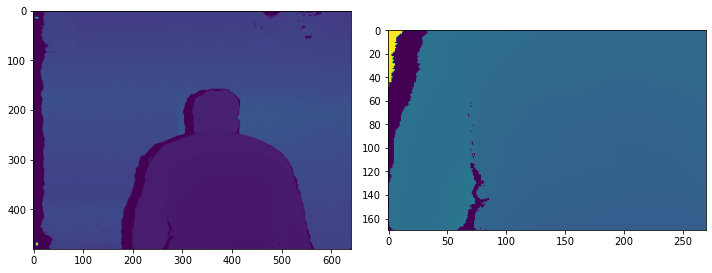

In [325]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
axes[0].imshow(depth_results[10][1]) 
axes[1].imshow(depth_results[10][1][310:,200:470])
fig.tight_layout()

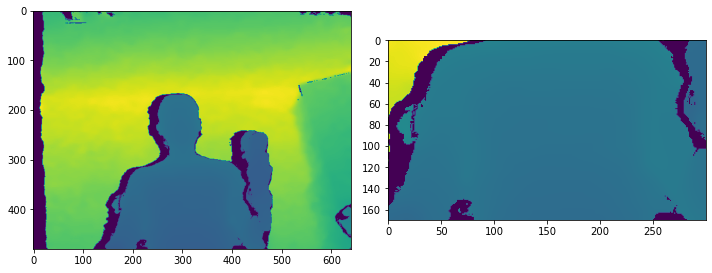

In [326]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
axes[0].imshow(depth_results[500][0])
axes[1].imshow(depth_results[500][0][310:500,150:450])
fig.tight_layout()

In [327]:
min_thresh, max_thresh = .5, 2
results = [device_manager.get_depth(x[0][310:450,220:400], min_thresh, max_thresh) for x in depth_results]
final_imgs, final_dist = np.array([x[0] for x in results]), np.array([x[1] for x in results])

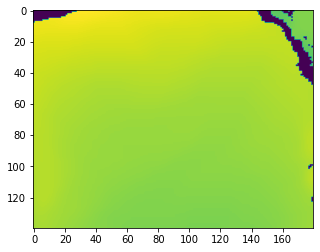

In [328]:
plt.imshow(final_imgs[400])

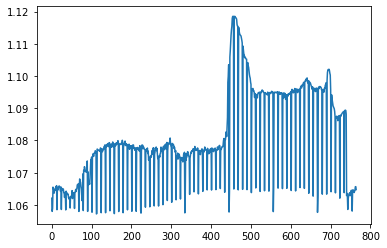

In [329]:
plt.plot(final_dist)

### Generate Point Clouds

In [730]:
depth_dir = 'D:/realsense_demos/dual_depth_demo_2/run_8_depth'
depth_images = np.array([np.load(os.path.join(depth_dir, x)) for x in os.listdir(depth_dir)])

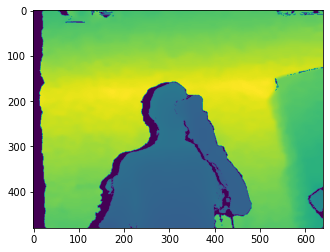

In [731]:
plt.imshow(depth_images[750][0])

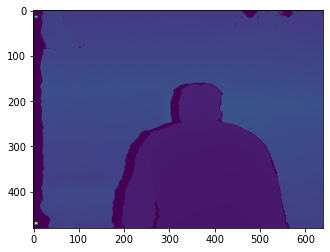

In [732]:
plt.imshow(depth_images[100][1])

In [752]:
min_thresh, max_thresh = .5, 2
results_front = [device_manager.get_depth(x[310:550,230:360], min_thresh, max_thresh) for x in depth_images[:,0,:,:]]
results_back = [device_manager.get_depth(x[260:,275:460], min_thresh, max_thresh) for x in depth_images[:,1,:,:]]
final_imgs_front, final_dist_front = np.array([x[0] for x in results_front]), np.array([x[1] for x in results_front])
final_imgs_back, final_dist_back = np.array([x[0] for x in results_back]), np.array([x[1] for x in results_back])

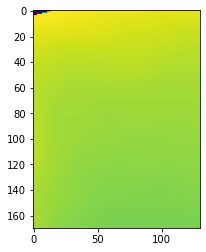

In [753]:
plt.imshow(final_imgs_front[100])

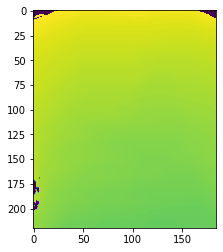

In [754]:
plt.imshow(final_imgs_back[0])

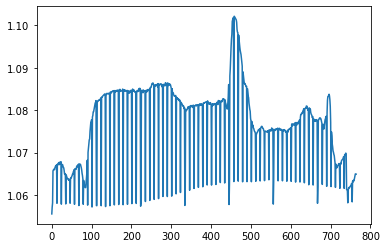

In [755]:
plt.plot(final_dist_front)

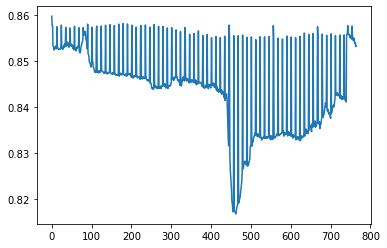

In [756]:
plt.plot(final_dist_back)

In [757]:
np.save('D:/realsense_demos/dual_depth_demo_2/run_8_dist_front.npy', final_dist_front)
np.save('D:/realsense_demos/dual_depth_demo_2/run_8_dist_back.npy', final_dist_back)

In [332]:
test_pcd = device_manager.compute_dual_point_clouds(depth_images[400])
o3d.visualization.draw_geometries([test_pcd])

In [311]:
# clip based on threshold
depth_images_front = np.array([device_manager.get_depth(x, min_thresh, max_thresh)[0] for x in depth_images[:,0,:,:]])
depth_images_back = np.array([device_manager.get_depth(x, .5, 1.5)[0] for x in depth_images[:,1,:,:]])
total_depth = np.array([(x, y) for x, y in zip(depth_images_front, depth_images_back)])

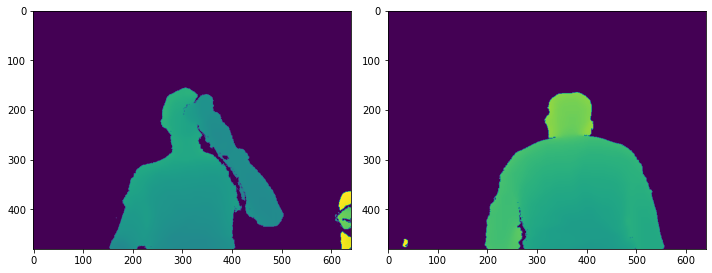

In [312]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
axes[0].imshow(total_depth[0][0])
axes[1].imshow(total_depth[0][1])
fig.tight_layout()

In [313]:
save_depth_stripped = 'D:\realsense_demos\dual_depth_demo_2\run_6_depth_stripped'
if not os.path.isdir(save_depth_stripped): 
    os.makedirs(save_depth_stripped)

for i, depth_imgs in enumerate(total_depth):
    np.save(os.path.join(save_depth_stripped, 'depth_img_stripped_' + str(i) + '.npy'), depth_imgs)

OSError: 614400 requested and 0 written

In [333]:
ply_path = 'D:/realsense_demos/dual_depth_demo_2/run_8_pcd'

# save to file 
if not os.path.isdir(ply_path): 
    os.makedirs(ply_path)
    
for count, imgs in enumerate(depth_images): 
    print(count)
    pcd = device_manager.compute_dual_point_clouds(imgs)
    o3d.io.write_point_cloud(os.path.join(ply_path, 'pc_data_' + str(count)+'.ply'), pcd)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Extra 

In [126]:
pts = np.asanyarray(single_pcd.points).copy()
pts = pts[np.where(pts[:,0] >= -.01)]
pts = pts[np.where(pts[:,0] < .7)]

# load to pcd point cloud  
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts)

In [128]:
o3d.visualization.draw_geometries([single_pcd])

In [134]:
np.asanyarray(single_pcd.points)[:,0].max()

1.5073921198371665

In [171]:
pts = np.asanyarray(single_pcd.points).copy()
pts = pts[np.where(pts[:,0] >= -.35)]
pts = pts[np.where(pts[:,0] < .08)]

# load to pcd point cloud  
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts)

In [168]:
o3d.visualization.draw_geometries([pcd])

In [ ]:
# cluster point clouds
labels = np.array(pcd.cluster_dbscan(eps=0.05, min_points=10, print_progress=True))
max_label = labels.max()
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

In [ ]:
o3d.visualization.draw_geometries([pcd])

In [2]:
device_manager._calibration_info_devices

NameError: name 'device_manager' is not defined

In [114]:
device_manager._transformation_devices

{'013422062082': <calibration_kabsch.Transformation at 0x180b00ea978>,
 '020122061309': <calibration_kabsch.Transformation at 0x180b00eabe0>}

In [112]:
device_manager._available_devices

['013422062082', '020122061309']

In [113]:
device_manager.disable_streams()

In [ ]:
{'013422062082': <calibration_kabsch.Transformation at 0x180b00ea978>,
 '020122061309': <calibration_kabsch.Transformation at 0x180b00eabe0>}  

### Compute & Load Metrics Information 

In [46]:
dist_data_dir = 'D:/realsense_demos/dual_depth_demo_2/'
run_name_front = 'run_2_dist_front.npy'
run_name_back = 'run_2_dist_back.npy'

distances_front = np.load(os.path.join(dist_data_dir, run_name_front))
distance_back = np.load(os.path.join(dist_data_dir, run_name_back))

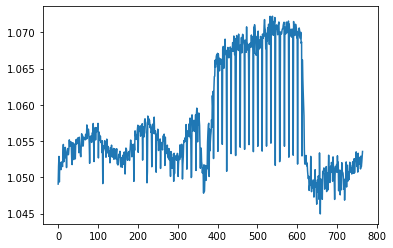

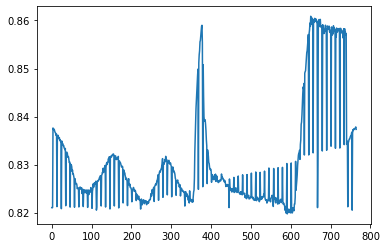

In [47]:
plt.figure(1)
plt.plot(distances_front)

plt.figure(2)
plt.plot(distance_back)

In [19]:
from scipy.signal import detrend
from scipy import signal
import pandas as pd

In [16]:
# loading chest volume variations
ysmoothed = detrend(distances_front)
ysmoothed = -ysmoothed

b, a = signal.butter(1, .03, analog=False)
ysmoothed = signal.filtfilt(b, a, ysmoothed)

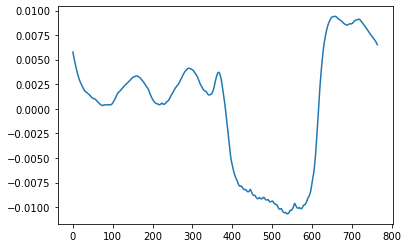

In [17]:
plt.plot(ysmoothed)

In [21]:
def get_depth(depth_img, min_threshold, max_threshold):
    
        # convert threshold meters to image scale 
        depth_scale = 0.0010000000474974513
        min_clipping_distance = min_threshold / depth_scale
        max_clipping_distance = max_threshold / depth_scale
        
        # clip based on threshold
        depth_img = np.where((depth_img > max_clipping_distance) | (depth_img <= min_clipping_distance), 0, depth_img)

        # Get data scale from the device and convert to meters
        depth_img = depth_img * depth_scale
        dist, _, _, _ = cv2.mean(depth_img)
       
        return depth_img, dist

In [22]:
depth_dir = 'D:/realsense_demos/dual_depth_demo_2/run_8_depth'
depth_images = np.array([np.load(os.path.join(depth_dir, x)) for x in os.listdir(depth_dir)])

In [23]:
front_depths = np.array([x for x in depth_images[:,0,:,:]])
back_depths = np.array([x for x in depth_images[:,1,:,:]])

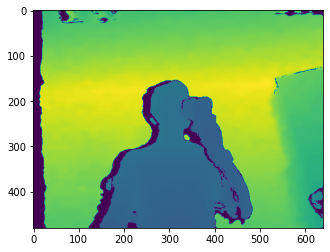

In [24]:
plt.imshow(front_depths[0])

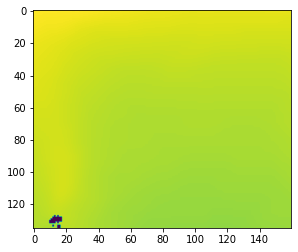

In [53]:
plt.imshow(front_depths[0][315:450,210:370])

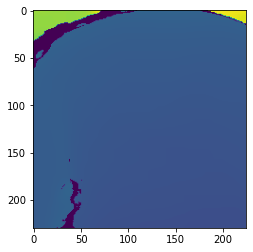

In [54]:
plt.imshow(back_depths[0][250:500,230:455])

In [234]:
dist_front = np.array([get_depth(x[305:415,215:375], .5, 2) for x in front_depths])
dist_back = np.array([get_depth(x[250:500,230:455], .5, 2) for x in back_depths])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [235]:
imgs_front = [x[0] for x in dist_front]
distances_front = [x[1] for x in dist_front]

imgs_back = [x[0] for x in dist_back]
distances_back = [x[1] for x in dist_back]

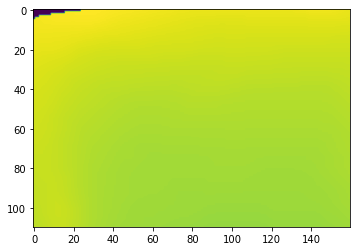

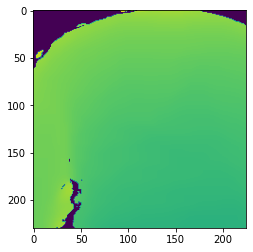

In [236]:
plt.figure(1)
plt.imshow(imgs_front[0])

plt.figure(2)
plt.imshow(imgs_back[0])

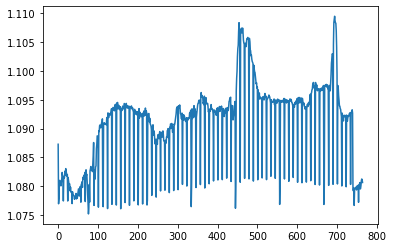

In [237]:
plt.plot(distances_front)

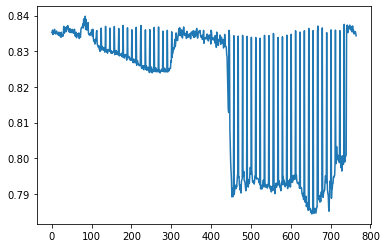

In [238]:
plt.plot(distances_back)

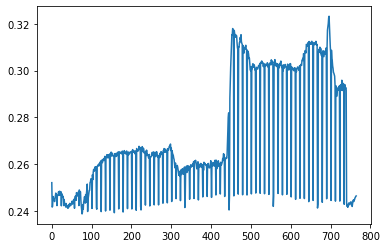

In [239]:
plt.plot(np.array(distances_front) - np.array(distances_back))

In [240]:
np.save('D:/realsense_demos/dual_depth_demo_2/run_8_dist_front', distances_front)
np.save('D:/realsense_demos/dual_depth_demo_2/run_8_dist_back', distances_back)

### Chest Models

In [3]:
ply_path = 'D:/realsense_demos/dual_depth_demo_2/run_2_pcd/'
ply_files = natsorted(os.listdir(ply_path))

pcd = o3d.io.read_point_cloud(os.path.join(ply_path, ply_files[50]))

In [592]:
pts = np.asanyarray(pcd.points).copy()
pts = pts[np.where(pts[:,1] >= -.01)]
pts = pts[np.where(pts[:,1] < .5)]

# load to pcd point cloud  
pcd_new = o3d.geometry.PointCloud()
pcd_new.points = o3d.utility.Vector3dVector(pts)

In [593]:
o3d.visualization.draw_geometries([pcd_new])

In [672]:
ply_path = 'D:/realsense_demos/dual_depth_demo_2/run_2_pcd/'
ply_files = natsorted(os.listdir(ply_path))
chest_vols = [] 
pcd_list = [] 

plt.figure(1)
for i, file in enumerate(ply_files[:1]): 
    
#     if os.path.isfile('./chest_render_movie/test_depth_' + str(i) + '.png'):
#         print('skipping ', i)
#         continue
        
#     print(i)
    
    pcd_temp = o3d.io.read_point_cloud(os.path.join(ply_path, file))
    
    pts = np.asanyarray(pcd_temp.points).copy()
    pts = pts[np.where(pts[:,1] >= -.01)]
    pts = pts[np.where(pts[:,1] < .5)]

    # load to pcd point cloud  
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts)
    
    all_points = np.asanyarray(pcd.points)
    points_m = np.zeros_like(all_points)
    
    x, y, z = all_points[:,0].copy(), all_points[:,1].copy(), all_points[:,2].copy()
    
    theta_z = 21.9
    theta_y = 43.7
    theta_x = 37.5

    points_m[:,0] = x 
    points_m[:,1] = (y * np.cos(theta_x)) - (z * np.sin(theta_x))
    points_m[:,2] = (y * np.sin(theta_x)) + (z * np.cos(theta_x))

    x, y, z = points_m[:,0].copy(), points_m[:,1].copy(), points_m[:,2].copy()

    points_m[:,0] = (x * np.cos(theta_z)) - (y * np.sin(theta_z))
    points_m[:,1] = (x * np.sin(theta_z)) + (y * np.cos(theta_z))
    points_m[:,2] = z

    x, y, z = points_m[:,0].copy(), points_m[:,1].copy(), points_m[:,2].copy()

    points_m[:,0] = (x * np.cos(theta_y)) + (z * np.sin(theta_y))
    points_m[:,1] = y
    points_m[:,2] =  (z * np.cos(theta_y)) - (x * np.sin(theta_y))
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_m)

#     cloud = pv.PolyData(points_m)
#     cloud.compute_normals(inplace=True)
    
#     cloud.plot(render_points_as_spheres=True, color='salmon', screenshot='./test_dual' + str(i) + '.png')

<Figure size 432x288 with 0 Axes>

In [674]:
#o3d.visualization.draw_geometries([pcd_temp])

In [269]:
# Import RealSense, OpenCV and NumPy
import pyrealsense2 as rs
import cv2
import numpy as np
import pyvista as pv
from pclpy import pcl
import open3d as o3d
import trimesh
import matplotlib.pyplot as plt

from natsort import natsorted

from interactivecrop.interactivecrop import main as crop 
from interactivecrop.samples import sample_images, sample_names

import os 
os.sys.path.append('./box_dimensioner_multicam/')

# Import helper functions and classes written to wrap the RealSense, OpenCV and Kabsch Calibration usage
from collections import defaultdict
from realsense_device_manager import DeviceManager
from calibration_kabsch import PoseEstimation
from helper_functions import get_boundary_corners_2D, convert_pointcloud_to_depth
from measurement_task import calculate_boundingbox_points, calculate_cumulative_pointcloud, visualise_measurements

from skimage import io
import matplotlib.animation as animation

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [267]:
ply_path = 'D:/realsense_demos/dual_depth_demo_2/run_8_pcd/'
ply_files = natsorted(os.listdir(ply_path))
chest_vols = [] 
pcd_list = [] 

theta_y = 44.9

plt.figure(1)
for i, file in enumerate(ply_files): 
    
#     if os.path.isfile('./chest_render_movie/test_depth_' + str(i) + '.png'):
#         print('skipping ', i)
#         continue
        
#     print(i)
    
    pcd_temp = o3d.io.read_point_cloud(os.path.join(ply_path, file))
    
    pts = np.asanyarray(pcd_temp.points).copy()
    pts = pts[np.where(pts[:,1] >= -.001)]
    pts = pts[np.where(pts[:,1] < .33)]

    # load to pcd point cloud  
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts)
    
    all_points = np.asanyarray(pcd.points)
    points_m = np.zeros_like(all_points)
    
    x, y, z = all_points[:,0].copy(), all_points[:,1].copy(), all_points[:,2].copy() 
    
    theta_z = 50.2
    theta_x = -39.3
    theta_y = 44.9 

    points_m[:,0] = x 
    points_m[:,1] = (y * np.cos(theta_x)) - (z * np.sin(theta_x))
    points_m[:,2] = (y * np.sin(theta_x)) + (z * np.cos(theta_x))

    x, y, z = points_m[:,0].copy(), points_m[:,1].copy(), points_m[:,2].copy()

    points_m[:,0] = (x * np.cos(theta_z)) - (y * np.sin(theta_z))
    points_m[:,1] = (x * np.sin(theta_z)) + (y * np.cos(theta_z))
    points_m[:,2] = z

    x, y, z = points_m[:,0].copy(), points_m[:,1].copy(), points_m[:,2].copy()

    points_m[:,0] = (x * np.cos(theta_y)) + (z * np.sin(theta_y))
    points_m[:,1] = y
    points_m[:,2] =  (z * np.cos(theta_y)) - (x * np.sin(theta_y))
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_m)
    
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.update_geometry(pcd)
    vis.poll_events()
    vis.update_renderer()
    vis.capture_screen_image('D:/realsense_demos/shallow_renderings/render_' + str(i) + '.png')
    vis.destroy_window()
    
#     if theta_y <= 44.9: 
#         theta_y -= .1

#     cloud = pv.PolyData(points_m)
#     cloud.compute_normals(inplace=True)
    
#     cloud.plot(render_points_as_spheres=True, color='salmon', screenshot='./test_dual' + str(i) + '.png')

print('finished')

finished


<Figure size 432x288 with 0 Axes>

In [255]:
volume_vals = np.load('D:/realsense_data/final_run_8/chest_vols_run_8.npy')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

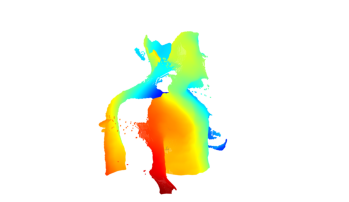

In [271]:
img_dir = 'D:/realsense_demos/shallow_renderings'
img_files = natsorted(os.listdir(img_dir))
imgs = np.array([io.imread(os.path.join(img_dir, x)) for x in img_files if x.endswith('.png')])

frames = [] # for storing the generated images
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axis('off')
for i in range(len(imgs)):
    print(i)
    img = ax.imshow(imgs[i], animated=True)
    #t = ax.text(500, 700, 'Computed Volume: ' + "{:.4f}".format(volume_vals[i]), fontweight='bold', color='white', bbox=dict(facecolor='red', alpha=0.5), horizontalalignment='center', verticalalignment='center')
    frames.append([img])

ani = animation.ArtistAnimation(fig, frames, interval=1000, blit=True)

writer = animation.FFMpegWriter(fps=15, bitrate=1000)
ani.save('D:/realsense_demos/dual_shallow_chest_vol_rendering.mp4', writer=writer, dpi=900)

print('Done ')